In [4]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import os
import glob
import numpy as np
from typing import Iterable
import pickle
from tqdm.notebook import tqdm
import tensorflow as tf
from scipy.fft import fft, ifft
from statsmodels.tsa.stattools import acf, pacf
from sklearn.decomposition import PCA

import keras
import keras_tuner as kt
from kerastuner import RandomSearch
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [22]:
# load a single shot using pandas parquet file reader 
def load_shot(shotnum: int) -> pd.DataFrame:
    shot = pd.read_parquet("../data/DISR_data/JET_DATAno" + str(shotnum) + ".parquet")
    return shot

shotnum = 96885
df_shot = load_shot(shotnum)
df_shot['IPE'] = df_shot['IPLA'] - df_shot['IPref']
display(df_shot)

,time,IPLA,IPref,ECEcore,SSXcore,LI,Q95,ZMAG,Vloop,IPE
0,0.022000,-53160.492188,0.022461,1141.500610,0.002289,0.661752,10.408838,0.020125,-17.961126,-53160.515625
1,0.023000,-56066.082031,0.022461,1141.500610,0.001373,0.661752,10.408838,0.020125,-17.642231,-56066.105469
2,0.024000,-59827.996094,0.022461,1141.500610,0.000916,0.661752,10.408838,0.020125,-18.239368,-59828.019531
3,0.025000,-63139.011719,0.022461,1141.500610,0.001679,0.661752,10.408838,0.020125,-18.200048,-63139.035156
4,0.026000,-66272.710938,0.022461,1141.500610,0.001221,0.661752,10.408838,0.020125,-17.801512,-66272.734375
...,...,...,...,...,...,...,...,...,...,...
16880,16.902000,-100682.593750,0.022461,1224.449097,0.002441,1.155780,3.558453,0.329814,-55.337883,-100682.617188
16881,16.903000,-96515.125000,0.022461,1224.449097,0.001831,1.155780,3.558453,0.329814,-49.116920,-96515.148438
16882,16.903999,-85514.335938,0.022461,1224.449097,0.002441,1.155780,3.558453,0.329814,-43.695698,-85514.359375
16883,16.905001,-70803.953125,0.022461,1224.449097,0.002899,1.155780,3.558453,0.329814,-37.757305,-70803.976562


In [58]:
model = tf.keras.models.load_model("../models/nn_window.keras")

window = 0

# Add 'Instability' and 'Window' attributes to the DataFrame
df_shot['Instability'] = 0
df_shot['Window'] = window
df_shot['Label'] = -1

# Define the window size and the number of samples with the same label required
window_size = 20
window_cursor_one = 0
window_cursor_two = window_size - 1
label_count = 15

# Iterate over the samples in the DataFrame
for i in tqdm(range(len(df_shot)), desc='Processing samples'):
    # Get the current sample
    sample = df_shot.iloc[i]
    
    # Perform the prediction using the Keras model
    prediction = model.predict(np.array([sample]))[0]
    label = np.argmax(prediction)

    df_shot.loc[i, 'Label'] = label

    max_label = df_shot['Label'].iloc[window_cursor_one : window_cursor_two].value_counts().max()
    
    # Check if there are enough samples with the same label in the window
    if max_label >= label_count and max_label != -1:
        window += 1
        # Set the window attribute for the samples inside the window
        df_shot.loc[window_cursor_one : window_cursor_two, 'Window'] = window

        # Set the label attribute for the samples inside the window
        df_shot.loc[window_cursor_one : window_cursor_two, 'Label'] = max_label
        
        # Move the window to the next 20 samples
        window_cursor_one += window_size
        window_cursor_two += window_size

        # Check if the label is 1
        if label == 1:
            # Increase the instability by 1 for all following samples
            df_shot.loc[i + 1:, 'Instability'] += 1

    elif i == window_cursor_two:
        # Move the window to the next samples
        window_cursor_one += 1
        window_cursor_two += 1

# Display the updated DataFrame
display(df_shot)

Processing samples:   0%|          | 0/16885 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


In [52]:
windows = df_shot[df_shot['Label'] == 1]['Window'].unique()

display(df_shot[df_shot['Window'] == windows[20]])

,time,IPLA,IPref,ECEcore,SSXcore,LI,Q95,ZMAG,Vloop,IPE,Instability,Window,Label
1160,1.182,-838739.8125,-825310.2500,1253.171143,0.007630,1.131199,6.097872,0.203220,-1.912041,-13429.5625,66,59,1
1161,1.183,-840914.2500,-825310.2500,1257.291016,0.007477,1.131199,6.097872,0.203220,-2.031336,-15604.0000,66,59,1
1162,1.184,-839739.1875,-827977.1875,1256.148682,0.006867,1.131199,6.097872,0.203220,-2.350231,-11762.0000,66,59,1
1163,1.185,-840095.4375,-827977.1875,1253.816650,0.006561,1.131199,6.097872,0.203220,-1.275249,-12118.2500,66,59,1
1164,1.186,-841241.4375,-827977.1875,1256.504395,0.006867,1.131199,6.097872,0.203220,-1.672453,-13264.2500,66,59,1
1165,1.187,-840995.4375,-827977.1875,1261.497070,0.006561,1.131199,6.097872,0.203220,-2.150630,-13018.2500,66,59,1
1166,1.188,-842178.8750,-827977.1875,1251.570435,0.007630,1.131199,6.097872,0.203220,-1.870722,-14201.6875,66,59,1
1167,1.189,-843018.1875,-827977.1875,1256.684814,0.007630,1.143787,6.264678,0.206482,-1.872054,-15041.0000,66,59,1
1168,1.190,-843763.8750,-827977.1875,1252.839478,0.007324,1.143787,6.264678,0.206482,-1.871388,-15786.6875,66,59,1
1169,1.191,-844171.2500,-827977.1875,1258.702881,0.007172,1.143787,6.264678,0.206482,-1.871388,-16194.0625,66,59,1


In [54]:
# Filter out rows where 'Window' is 0
df_shot_filtered = df_shot[df_shot['Window'] != 0]

# Remove the 'Label' column
df_shot_modified = df_shot_filtered.drop(columns=['Label'])

# Save the DataFrame as a csv file
df_shot_modified.to_csv("../data/pipeline.csv", index=False)

(844, 20, 11)

In [84]:
# Load the DataFrame from the csv file
dataset = pd.read_csv("../data/pipeline.csv")

# Rename the 'time' column to 'Time'
dataset.rename(columns={'time': 'Time'}, inplace=True)

# Drop the 'IPE' and 'Instability' columns and group the DataFrame by 'Window'
grouped = dataset.drop(columns=['IPE', 'Instability']).groupby('Window')

# Define columns to perform feature engineering on
columns = ['Time', 'IPLA', 'IPref', 'ECEcore', 'SSXcore', 'LI', 'Q95', 'ZMAG', 'Vloop']

# Define the operations to perform on each column
operations = {
    'fft_abs': lambda x: np.abs(np.fft.fft(x)),
    'der': np.gradient,
    'der2': lambda x: np.gradient(np.gradient(x))
}

df_data = pd.DataFrame()
window = 0

# Iterate over the groups
for name, group in grouped:
    # Create a DataFrame for the group
    df = pd.DataFrame(group.values, columns=group.columns)

    # Add the IPE column
    df['IPE'] = np.abs(df['IPLA'] - df['IPref'])

    # Perform feature engineering on each column
    new_cols = {}
    for col in columns:
        for op_name, op_func in operations.items():
            new_cols[col + '_' + op_name] = op_func(df[col])

    # Create a new DataFrame with the new columns
    df_new = pd.DataFrame(new_cols)

    # Concatenate the original DataFrame with the new one
    df = pd.concat([df, df_new], axis=1)

    # Add the Frame, Shot and Window columns
    df['Frame'] = range(0, 20)
    df['Shot'] = shotnum
    df['Window'] = window  # Add the window number
    window += 1

    contains_nan = df.isna().any().any()

    if not contains_nan:
        # Append the current DataFrame to the main DataFrame
        df_data = pd.concat([df_data, df], ignore_index=True)
    
    
df_data = df_data.dropna()
display(df_data)

,Time,IPLA,IPref,ECEcore,SSXcore,LI,Q95,ZMAG,Vloop,Window,...,Q95_der,Q95_der2,ZMAG_fft_abs,ZMAG_der,ZMAG_der2,Vloop_fft_abs,Vloop_der,Vloop_der2,Frame,Shot
0,0.022,-53160.492,0.022461,1141.5006,0.002289,0.661752,10.408838,0.020125,-17.961126,0,...,0.0,0.0,0.402509,0.0,0.0,353.277136,0.318895,-0.458016,0,96885
1,0.023,-56066.082,0.022461,1141.5006,0.001373,0.661752,10.408838,0.020125,-17.642231,0,...,0.0,0.0,0.000000,0.0,0.0,3.339015,-0.139121,-0.298902,1,96885
2,0.024,-59827.996,0.022461,1141.5006,0.000916,0.661752,10.408838,0.020125,-18.239368,0,...,0.0,0.0,0.000000,0.0,0.0,0.318748,-0.278909,0.179024,2,96885
3,0.025,-63139.010,0.022461,1141.5006,0.001679,0.661752,10.408838,0.020125,-18.200048,0,...,0.0,0.0,0.000000,0.0,0.0,1.357657,0.218928,0.219095,3,96885
4,0.026,-66272.710,0.022461,1141.5006,0.001221,0.661752,10.408838,0.020125,-17.801512,0,...,0.0,0.0,0.000000,0.0,0.0,1.179940,0.159281,-0.179274,4,96885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16875,16.897,-125845.310,0.022461,1224.4491,0.000763,1.155780,3.558453,0.329814,-106.415500,843,...,0.0,0.0,0.000000,0.0,0.0,100.534729,13.177520,-0.308229,15,96885
16876,16.898,-116508.960,0.022461,1224.4491,0.002747,1.155780,3.558453,0.329814,-93.338440,843,...,0.0,0.0,0.000000,0.0,0.0,114.099104,12.400278,-1.046492,16,96885
16877,16.899,-111078.960,0.022461,1224.4491,0.002594,1.155780,3.558453,0.329814,-81.614944,843,...,0.0,0.0,0.000000,0.0,0.0,154.818630,11.084535,-1.524588,17,96885
16878,16.900,-108135.440,0.022461,1224.4491,0.001526,1.155780,3.558453,0.329814,-71.169370,843,...,0.0,0.0,0.000000,0.0,0.0,257.682923,9.351102,-1.413953,18,96885


In [85]:
df_data.columns

Index(['Time', 'IPLA', 'IPref', 'ECEcore', 'SSXcore', 'LI', 'Q95', 'ZMAG',
       'Vloop', 'Window', 'IPE', 'Time_fft_abs', 'Time_der', 'Time_der2',
       'IPLA_fft_abs', 'IPLA_der', 'IPLA_der2', 'IPref_fft_abs', 'IPref_der',
       'IPref_der2', 'ECEcore_fft_abs', 'ECEcore_der', 'ECEcore_der2',
       'SSXcore_fft_abs', 'SSXcore_der', 'SSXcore_der2', 'LI_fft_abs',
       'LI_der', 'LI_der2', 'Q95_fft_abs', 'Q95_der', 'Q95_der2',
       'ZMAG_fft_abs', 'ZMAG_der', 'ZMAG_der2', 'Vloop_fft_abs', 'Vloop_der',
       'Vloop_der2', 'Frame', 'Shot'],
      dtype='object')

In [86]:
# Group by 'Window' and 'Shot', and reshape the data
new_data_grouped = df_data.sort_values(['Shot', 'Window', 'Time']).groupby(['Shot', 'Window'])

# Prepare a list to hold sequences
X_new_grouped = []

# Generate sequences for new data
for _, group in new_data_grouped:
    X_new_grouped.append(group.drop(columns=['Frame', 'Shot', 'Window']).values)

# Convert list to numpy array
X_new_grouped = np.array(X_new_grouped)

# Load the scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Normalize the features using the same scaler fitted on the training data
X_new = scaler.transform(X_new_grouped.reshape(-1, X_new_grouped.shape[-1])).reshape(X_new_grouped.shape)

In [87]:
X_new.shape

(844, 20, 37)

27/27 [==============================] - 0s 4ms/step


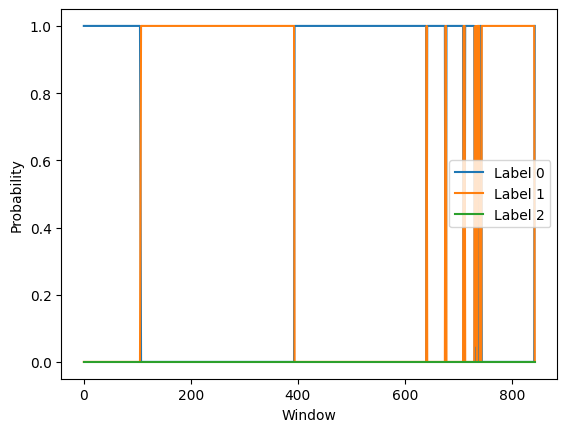

In [88]:
# Load the model
model = tf.keras.models.load_model("../models/resnet.keras")

# Perform predictions on the new data
predictions = model.predict(X_new)

# Get the number of labels
num_labels = predictions.shape[1]

# Create a new figure
plt.figure()

# Plot the probability for each label
for i in range(num_labels):
    plt.plot(df_data['Window'].unique(), predictions[:, i], label=f'Label {i}')

# Add a legend
plt.legend()

# Add labels for the x and y axes
plt.xlabel('Window')
plt.ylabel('Probability')

# Show the plot
plt.show()

In [89]:
# Get the probabilities for class 2
class_2_probs = predictions[:, 2]

# Get the rows where the probability for class 2 is greater than 0
rows = predictions[class_2_probs > 0]

print(f'Number of rows: {len(rows)}')

Number of rows: 0


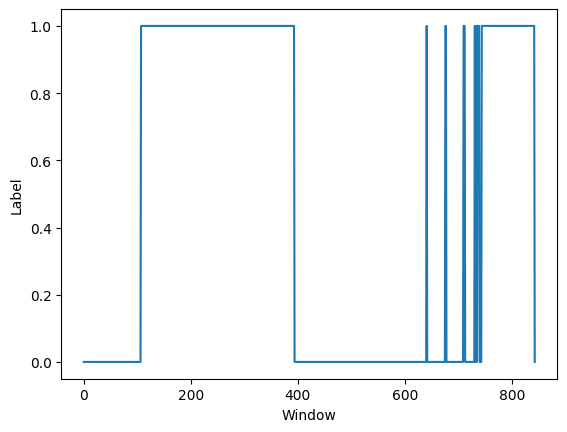

In [90]:
labels = []

for pred in predictions:
    if pred[2] > 0.2:
        labels.append(2)
    else:
        labels.append(np.argmax(pred))

# Get the unique windows
windows = df_data['Window'].unique()

# Create a new figure
plt.figure()

# Plot the labels with respect to the windows
plt.plot(windows, labels)

# Add labels for the x and y axes
plt.xlabel('Window')
plt.ylabel('Label')

# Show the plot
plt.show()


In [91]:
print(len(labels))
print(len(windows))

844
844


In [95]:
# load dataset using pickle
import pickle
with open("../data/dataset_disruption_characterization.pickle", "rb") as f:
    dataset = pickle.load(f)

In [96]:
# Define columns to perform feature engineering on
columns = ['IPLA', 'IPref', 'IPE', 'ECEcore', 'SSXcore', 'LI', 'Q95', 'ZMAG', 'Vloop']

# Define the operations to perform on each column
operations = {
    'fft_abs': lambda x: np.abs(np.fft.fft(x)),
    'der': np.gradient,
    'der2': lambda x: np.gradient(np.gradient(x))
}

df_data_loaded = pd.DataFrame()

# Loop through each entry in the dataset
for i, entry in enumerate(dataset):
    # Extract data and label from the current entry
    d = entry['x']
    label = entry['y']
    metadata = entry['metadata']
    event = metadata['time_event']

    # Create a DataFrame for the current entry
    df = pd.DataFrame(d['data'], columns=d['columns'])

    # Add the IPE column
    df['IPE'] = np.abs(df['IPLA'] - df['IPref'])

    # Perform feature engineering on each column
    new_cols = {}
    for col in columns:
        for op_name, op_func in operations.items():
            new_cols[col + '_' + op_name] = op_func(df[col])

    # Create a new DataFrame with the new columns
    df_new = pd.DataFrame(new_cols)

    # Concatenate the original DataFrame with the new one
    df = pd.concat([df, df_new], axis=1)
    
    # Add the time column
    df['Time'] = d['time']

    # Add the Frame, Event, Label, Shot and Window columns
    df['Frame'] = range(0, 20)
    df['Event'] = event if event else 0

    if event:
        # Find closest points to time_event
        differences = np.abs(df['Time'] - event)
        closest_indices = np.argsort(differences)[:20]

        # Assign labels to closest points
        df['Label'] = 0
        df.loc[closest_indices, 'Label'] = label
    else:
        df['Label'] = label

    df['Shot'] = metadata['shot']
    df['Window'] = i  # Add the window number

    contains_nan = df.isna().any().any()

    if not contains_nan:
        # Append the current DataFrame to the main DataFrame
        df_data_loaded = pd.concat([df_data_loaded, df], ignore_index=True)

df_data_loaded = df_data_loaded.dropna()
display(df_data_loaded)
print("Labels count:")
print(f"{df_data_loaded['Label'].value_counts()}")

,IPLA,IPref,ECEcore,SSXcore,LI,Q95,ZMAG,Vloop,IPE,IPLA_fft_abs,...,ZMAG_der2,Vloop_fft_abs,Vloop_der,Vloop_der2,Time,Frame,Event,Label,Shot,Window
0,1989456.750,1999500.0,1740.929077,0.008850,1.191489,3.874169,0.30388,-0.519496,10043.250,3.978742e+07,...,0.0,15.597891,-0.238922,-0.019993,10.361,0,0.0,0,81206,0
1,1989606.250,1999500.0,1744.737427,0.008850,1.191489,3.874169,0.30388,-0.758418,9893.750,2.153723e+03,...,0.0,1.771412,-0.258915,0.119461,10.362,1,0.0,0,81206,0
2,1988484.000,1999500.0,1756.823730,0.008698,1.191489,3.874169,0.30388,-1.037327,11016.000,4.264020e+03,...,0.0,3.078187,0.000000,0.448103,10.363,2,0.0,0,81206,0
3,1989329.625,1999500.0,1756.823730,0.008469,1.191489,3.874169,0.30388,-0.758418,10170.375,5.440219e+03,...,0.0,2.395747,0.637292,-0.159448,10.364,3,0.0,0,81206,0
4,1990532.250,1999500.0,1746.057251,0.008850,1.191489,3.874169,0.30388,0.237256,8967.750,4.025099e+03,...,0.0,2.711081,-0.318896,-0.537741,10.365,4,0.0,0,81206,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17975,3993662.500,4000500.0,6282.263672,1.416517,0.808256,2.898196,0.32961,-0.316564,6837.500,1.188296e+04,...,0.0,3.688298,-0.138622,0.138705,8.622,15,0.0,0,98005,905
17976,3995614.250,4000500.0,6303.055664,1.410871,0.808256,2.898196,0.32961,-0.237256,4885.750,6.513881e+03,...,0.0,2.476415,0.038821,0.198435,8.623,16,0.0,0,98005,905
17977,3994348.000,4000500.0,6277.216309,1.402783,0.808256,2.898196,0.32961,-0.238922,6152.000,9.370845e+03,...,0.0,2.202090,0.258249,0.000416,8.624,17,0.0,0,98005,905
17978,3997734.500,4000500.0,6286.124512,1.391034,0.808256,2.898196,0.32961,0.279242,2765.500,1.626988e+04,...,0.0,1.736529,0.039654,-0.348553,8.625,18,0.0,0,98005,905


Labels count:
Label
0    12840
1     4140
2     1000
Name: count, dtype: int64


In [151]:
# Selecting multiple columns correctly
df_comp = df_data_loaded[['Shot', 'Time', 'Label', 'Window']]

# Filtering df_data for a specific shot number
df_ref_shot = df_comp[df_comp['Shot'] == shotnum]


display(df_ref_shot.head())

# Resetting Label column to 0
df_data['Label_pred'] = 0

# Correcting the loop to iterate over windows
for i, window in enumerate(windows):
    df_data.loc[df_data['Window'] == window, 'Label_pred'] = labels[i]

# Display the DataFrame
display(df_data[['Time', 'Label_pred', 'Shot']].head())

,Shot,Time,Label,Window
10620,96885,16.840000,1,531
10621,96885,16.841000,1,531
10622,96885,16.841999,1,531
10623,96885,16.843000,1,531
10624,96885,16.844000,1,531


,Time,Label_pred,Shot
0,0.022,0,96885
1,0.023,0,96885
2,0.024,0,96885
3,0.025,0,96885
4,0.026,0,96885


In [153]:
# Convert 'Time' to string and then back to float
df_ref_shot['Time'] = df_ref_shot['Time'].astype(str).astype(float)
df_data['Time'] = df_data['Time'].astype(str).astype(float)

# Perform the merge
df_joined = pd.merge(df_ref_shot[['Time', 'Label']], 
                     df_data[['Time', 'Label_pred']], 
                     on='Time')

# Display the joined DataFrame
display(df_joined)

/var/folders/9z/qyx6tbz50h702rhr6ydchnfc0000gn/T/ipykernel_2219/3756955307.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ref_shot['Time'] = df_ref_shot['Time'].astype(str).astype(float)


,Time,Label,Label_pred
0,16.840,1,1
1,16.841,1,1
2,16.842,1,1
3,16.843,1,1
4,16.844,1,1
5,16.845,1,1
6,16.846,1,1
7,16.847,1,1
8,16.848,1,1
9,16.849,1,1


[531 532 533]
